In [4]:
import pandas as pd
import os
import shutil
import yaml
from pathlib import Path
import ast
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
from PIL import Image
from typing import List, Tuple, Dict
from tqdm.notebook import tqdm

In [5]:
image_path = "/kaggle/input/vindr-mammogram-dataset-dicom-to-png/images_png/"
directory = Path(image_path)
file_paths = list(directory.glob("*"))
len(file_paths)

5000

In [6]:
data = pd.read_csv('/kaggle/input/vindr-findings/vindr_detection_v1_folds.csv')
data['finding_categories'] = data['finding_categories'].apply(ast.literal_eval)
data= data.drop(['height','width','xmin','ymin','xmax','ymax','fold',
           'Architectural_Distortion', 'Asymmetry', 'Focal_Asymmetry',
           'Global_Asymmetry', 'Mass', 'Nipple_Retraction', 'No_Finding',
           'Skin_Retraction', 'Skin_Thickening', 'Suspicious_Calcification',
           'Suspicious_Lymph_Node', 'density'],axis=1)
data.head()

/tmp/ipykernel_30/1866978474.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/kaggle/input/vindr-findings/vindr_detection_v1_folds.csv')


,patient_id,series_id,image_id,laterality,view,breast_birads,breast_density,finding_categories,finding_birads,split,resized_xmin,resized_ymin,resized_xmax,resized_ymax
0,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,4e3a578fe535ea4f5258d3f7f4419db8.png,R,CC,BI-RADS 4,DENSITY C,[Mass],BI-RADS 4,training,485.695624,985.773942,609.595900,1078.419728
1,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,dac39351b0f3a8c670b7f8dc88029364.png,R,MLO,BI-RADS 4,DENSITY C,[Mass],BI-RADS 4,training,532.399692,743.812744,639.422675,812.095390
2,75e8e48933289d70b407379a564f8594,853b70e7e6f39133497909d9ca4c756d,c83f780904f25eacb44e9030f32c66e1.png,R,CC,BI-RADS 3,DENSITY C,[Global Asymmetry],BI-RADS 3,training,368.152714,499.060222,816.519337,1287.129503
3,75e8e48933289d70b407379a564f8594,853b70e7e6f39133497909d9ca4c756d,893528bc38a0362928a89364f1b692fd.png,R,MLO,BI-RADS 3,DENSITY C,[Global Asymmetry],BI-RADS 3,training,162.492921,726.730749,729.029452,1105.680056
4,c3487424fee1bdd4515b72dc3fd69813,77619c914263eae44e9099f1ce07192c,318264c881bf12f2c1efe5f93920cc37.png,R,CC,BI-RADS 4,DENSITY C,[Architectural Distortion],BI-RADS 4,training,403.582493,1078.254802,580.267104,1203.183844


In [7]:
def display_images(data, idx):
    # Find the unique patient ID
    unique_patient_id = data['patient_id'][idx]
    
    # Filter data for this patient ID
    patient_data = data[data['patient_id'] == unique_patient_id]
    
    # Set the plot size
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 5))
    axes = axes.ravel()

    for i, row in enumerate(patient_data.itertuples()):
        # Build image path
        img_file_path = os.path.join(image_path, row.patient_id, f"{row.image_id}")

        # Open and show image
        if os.path.exists(img_file_path):
            img = Image.open(img_file_path)
            try:
                axes[i].imshow(img, cmap='gray')
                
                # Draw bounding box
                rect = patches.Rectangle((row.resized_xmin, row.resized_ymin),
                                         row.resized_xmax - row.resized_xmin,
                                         row.resized_ymax - row.resized_ymin,
                                         linewidth=1, edgecolor='r', facecolor='none')
                axes[i].add_patch(rect)
            except Exception as e:
                print(f"Cannot Display {img_file_path}, because of error:{e}")
                break
        else:
            axes[i].text(0.5, 0.5, 'Image not found', horizontalalignment='center', verticalalignment='center')
        
        # Set title with image attributes
        title_text = f"{i} Laterality: {row.laterality}, View: {row.view}, BIRADS: {row.breast_birads}, " \
                     f"Density: {row.breast_density}, Findings: {','.join(row.finding_categories)}"
        axes[i].set_title(title_text, fontsize=8)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()


In [8]:
dw = data[~data['resized_xmin'].isnull()].copy() #Data containing Bounding Boxes, which is our focus for Object Detection
dw

,patient_id,series_id,image_id,laterality,view,breast_birads,breast_density,finding_categories,finding_birads,split,resized_xmin,resized_ymin,resized_xmax,resized_ymax
0,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,4e3a578fe535ea4f5258d3f7f4419db8.png,R,CC,BI-RADS 4,DENSITY C,[Mass],BI-RADS 4,training,485.695624,985.773942,609.595900,1078.419728
1,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,dac39351b0f3a8c670b7f8dc88029364.png,R,MLO,BI-RADS 4,DENSITY C,[Mass],BI-RADS 4,training,532.399692,743.812744,639.422675,812.095390
2,75e8e48933289d70b407379a564f8594,853b70e7e6f39133497909d9ca4c756d,c83f780904f25eacb44e9030f32c66e1.png,R,CC,BI-RADS 3,DENSITY C,[Global Asymmetry],BI-RADS 3,training,368.152714,499.060222,816.519337,1287.129503
3,75e8e48933289d70b407379a564f8594,853b70e7e6f39133497909d9ca4c756d,893528bc38a0362928a89364f1b692fd.png,R,MLO,BI-RADS 3,DENSITY C,[Global Asymmetry],BI-RADS 3,training,162.492921,726.730749,729.029452,1105.680056
4,c3487424fee1bdd4515b72dc3fd69813,77619c914263eae44e9099f1ce07192c,318264c881bf12f2c1efe5f93920cc37.png,R,CC,BI-RADS 4,DENSITY C,[Architectural Distortion],BI-RADS 4,training,403.582493,1078.254802,580.267104,1203.183844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2249,b8acac150be7f949f78dc631a3851f8b,f351166fe105bea6f090e38f41bc844c,bdf1539e07e60cfcb5e7833f5b63fa86.png,R,MLO,BI-RADS 4,DENSITY C,[Mass],BI-RADS 4,test,279.176226,792.258613,407.932101,881.475757
2250,b8acac150be7f949f78dc631a3851f8b,f351166fe105bea6f090e38f41bc844c,bdf1539e07e60cfcb5e7833f5b63fa86.png,R,MLO,BI-RADS 4,DENSITY C,[Mass],BI-RADS 4,test,87.032847,1060.220658,365.645343,1251.059411
2251,b8acac150be7f949f78dc631a3851f8b,f351166fe105bea6f090e38f41bc844c,bdf1539e07e60cfcb5e7833f5b63fa86.png,R,MLO,BI-RADS 4,DENSITY C,[Mass],BI-RADS 4,test,307.509650,1182.121037,484.871511,1261.599939
2252,0bfd4fcebaba4e9c4086edd05044a75f,255af1dcf2e5342bcc6bae1fc1a918cd,997e15346547ff56b4209ac73e74556f.png,L,MLO,BI-RADS 4,DENSITY C,"[Suspicious Calcification, Focal Asymmetry]",BI-RADS 4,training,71.254133,753.280013,737.398896,1184.495964


In [9]:
#There are rows with more than one category, but only one BBOX Co-ordinate
#How do we match what category belongs to the BBOX Co-ordinate

dw[dw['finding_categories'].apply(len)>=2].head(10)

,patient_id,series_id,image_id,laterality,view,breast_birads,breast_density,finding_categories,finding_birads,split,resized_xmin,resized_ymin,resized_xmax,resized_ymax
8,7c51789da6c462e55bcb95c2a7d437ee,ac4d0771f6d7a7400ab463458f789dbe,f581ef53bb7e61f4575db33eceac8ff8.png,L,CC,BI-RADS 4,DENSITY C,"[Nipple Retraction, Mass]",BI-RADS 4,training,607.868846,700.577727,840.541260,951.560194
9,7c51789da6c462e55bcb95c2a7d437ee,ac4d0771f6d7a7400ab463458f789dbe,1142cdfbfe725d62038252693cf064e5.png,L,MLO,BI-RADS 4,DENSITY C,"[Nipple Retraction, Mass]",BI-RADS 4,training,609.653523,895.515554,899.498433,1136.661553
21,e233b75f7dc52e0ea37c88ad1c4df17d,1a1f62519a7fb1fd022e0bdae77786b7,8c799782afb5ab3a1a9cd5236dbddb98.png,L,CC,BI-RADS 4,DENSITY C,"[Suspicious Calcification, Focal Asymmetry]",BI-RADS 4,training,57.717727,485.310409,223.034572,675.276620
22,e233b75f7dc52e0ea37c88ad1c4df17d,1a1f62519a7fb1fd022e0bdae77786b7,a869427ece4cb34d43825be65705929b.png,L,MLO,BI-RADS 4,DENSITY C,"[Suspicious Calcification, Focal Asymmetry]",BI-RADS 4,training,409.876373,565.055277,646.440383,702.091296
37,b57b97020df361371ae1877080433275,9faef5a6512d0c95927d9140c6be0d02,5fe8350c930a08ebc532cbb304f5642a.png,L,CC,BI-RADS 5,DENSITY C,"[Suspicious Calcification, Architectural Disto...",BI-RADS 4,test,298.183796,518.408508,562.021557,721.082458
42,b7e4e3564d6a1e087343250e95f38ff4,dd06a3b828779d8791daebb747405dc4,96cbdda19cf07be8e00db80d3c076e3c.png,L,CC,BI-RADS 5,DENSITY C,"[Suspicious Calcification, Mass]",BI-RADS 5,training,134.995129,360.852253,453.259673,583.715366
43,b7e4e3564d6a1e087343250e95f38ff4,dd06a3b828779d8791daebb747405dc4,8ccbc18df717a107769beedde21a14a3.png,L,MLO,BI-RADS 5,DENSITY C,"[Suspicious Calcification, Mass]",BI-RADS 5,training,353.907336,796.749236,641.432805,1051.755892
115,eeb18c719cadabcc5ec397a53be529db,eb3dd503e7fcb45cdfad5595c3b314d7,5fd515ea4eaec3493943c4eef796b41e.png,L,CC,BI-RADS 3,DENSITY C,"[Suspicious Calcification, Focal Asymmetry]",BI-RADS 3,training,289.337364,850.889768,456.606019,1033.820452
117,eeb18c719cadabcc5ec397a53be529db,eb3dd503e7fcb45cdfad5595c3b314d7,4494c6e2c08435784d5b1f25ac7b5869.png,L,MLO,BI-RADS 3,DENSITY C,"[Suspicious Calcification, Focal Asymmetry]",BI-RADS 3,training,287.152896,1100.296050,513.070955,1269.209004
122,d3248d8a3e782458ecd435ccbb69acb2,131e5987e7f790fe994d283f122e0ea2,8544f5b224566c38928fd793d2f5870a.png,R,MLO,BI-RADS 4,DENSITY B,"[Nipple Retraction, Asymmetry]",BI-RADS 4,training,98.459916,1148.501384,319.398627,1271.234094


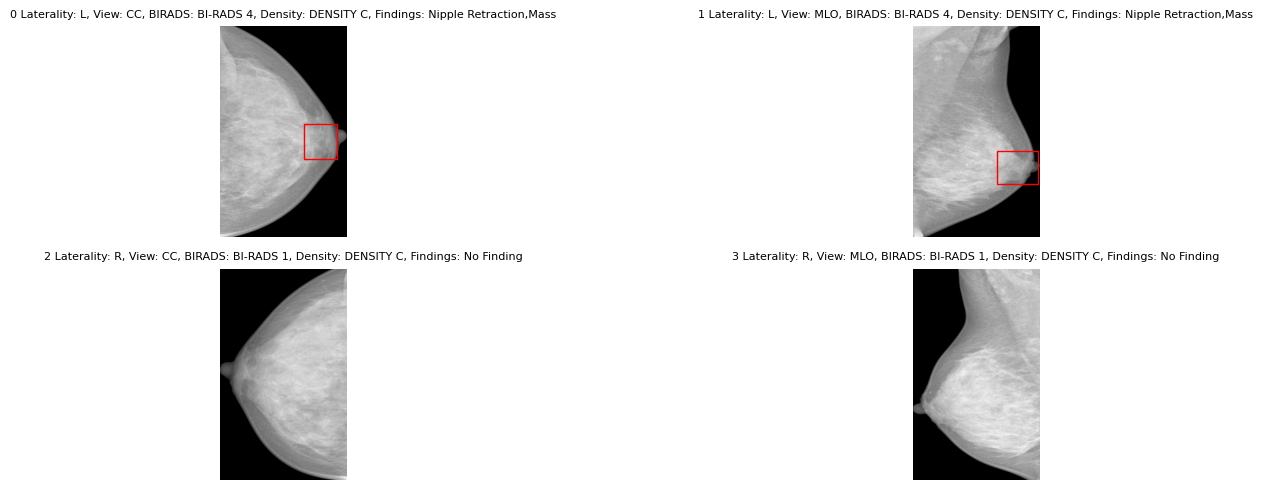

In [10]:
#Let's view a sample of this 

display_images(data, 8)

#How do we differentiate which bounding box represents Mass or Nipple Retraction? The 2nd Frame looks more like Nipple Retraction

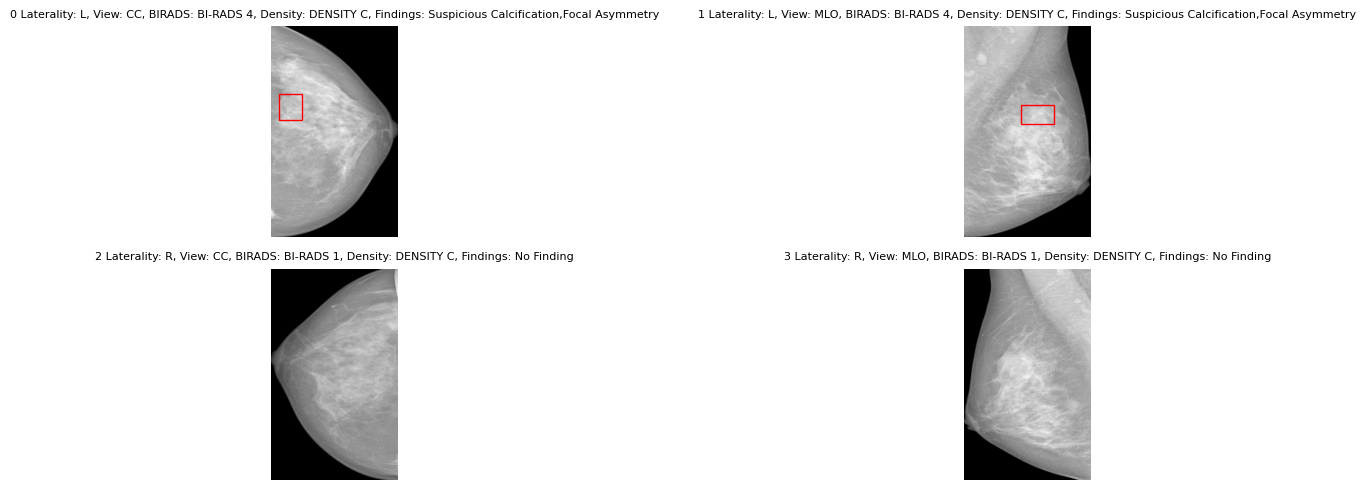

In [11]:
display_images(data, 21)

#How do we differentiate in this case between what Bounding Box belongs to Suspicious Calcification or Focal Asymmetry? The Bounding Box can represent both Categories

Cannot Display /kaggle/input/vindr-mammogram-dataset-dicom-to-png/images_png/b57b97020df361371ae1877080433275/7a6c57ce6034053ca02a8cd32549db7f.png, because of error:index 4 is out of bounds for axis 0 with size 4


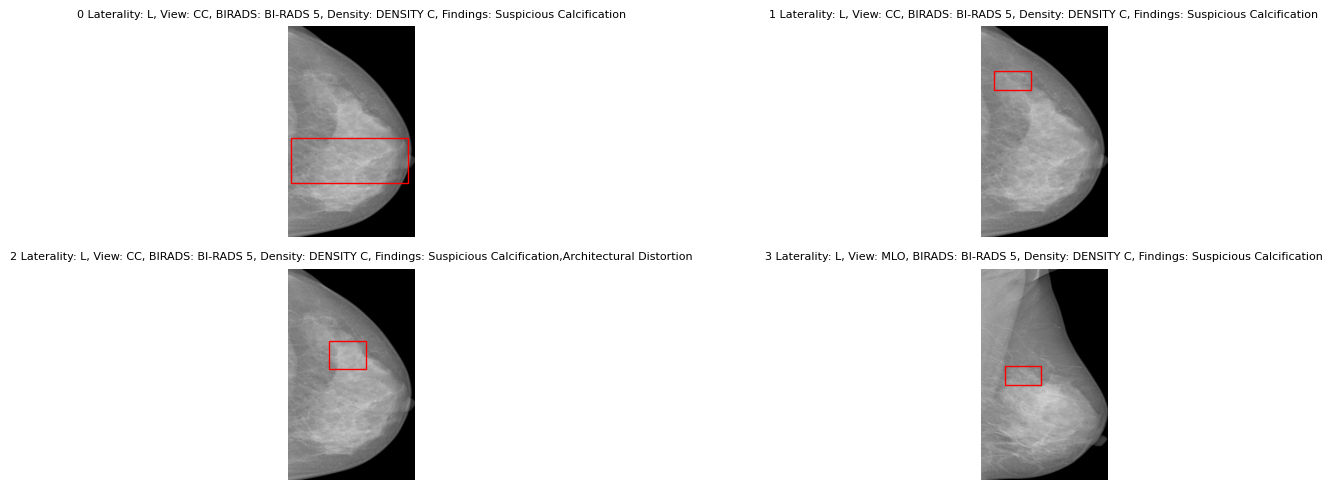

In [12]:
display_images(data, 37)

In [13]:
from collections import defaultdict

category = defaultdict(int)

for i, row in dw.iterrows():
    cats = row['finding_categories']
    for cat in cats:
        category[cat] += 1

category

defaultdict(int,
            {'Mass': 1226,
             'Global Asymmetry': 26,
             'Architectural Distortion': 119,
             'Nipple Retraction': 37,
             'Suspicious Calcification': 543,
             'Focal Asymmetry': 269,
             'Asymmetry': 97,
             'Skin Thickening': 57,
             'Suspicious Lymph Node': 57,
             'Skin Retraction': 18})

In [14]:
#To solve our problem of overlapping abnormalities for one bounding box, we decide to use a weighting function, based on the number of
# samples belonging to each unique abnormality, anywhere we find overlapping abnormalities, we take the abnormality which has a higher weight in terms of frequency

def chosen_category(cats:List) -> str:
    weights = []
    for cat in cats:
        weights.append(category[cat])

    idx = np.argmax(weights)
    return cats[idx]


dw['category'] = dw['finding_categories'].apply(chosen_category)
    

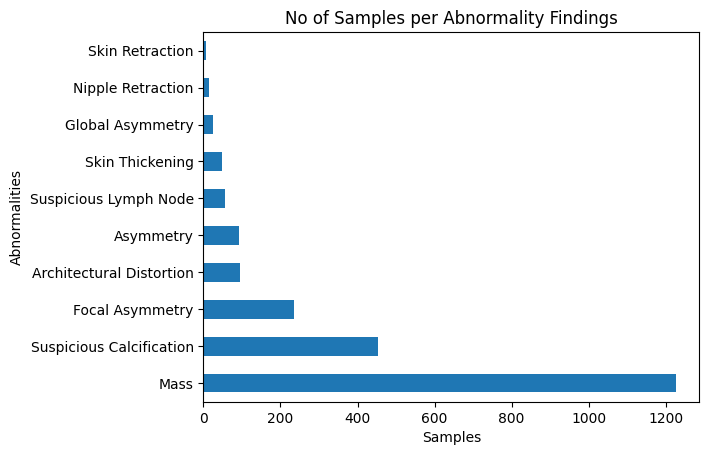

In [15]:
dw['category'].value_counts().plot(kind='barh', title="No of Samples per Abnormality Findings", ylabel="Abnormalities", xlabel="Samples");

How does the distribution of our breast birads for those with abnormality findings compare to those without?

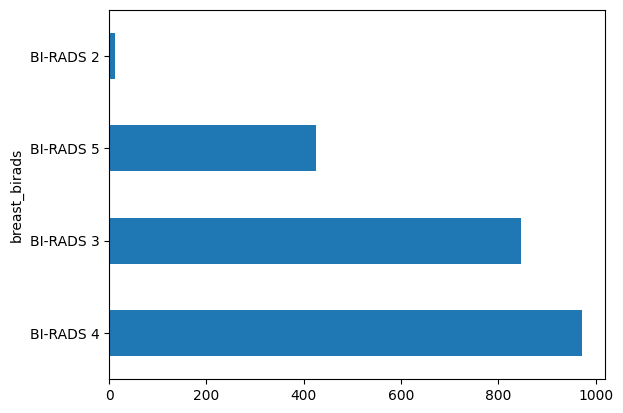

In [16]:
dw['breast_birads'].value_counts().plot(kind='barh');

#BI-RADS 4 & BI-RADS 3 are the most prevalent, this is understandable as those are the highest diagnostic indicators of breast cancer

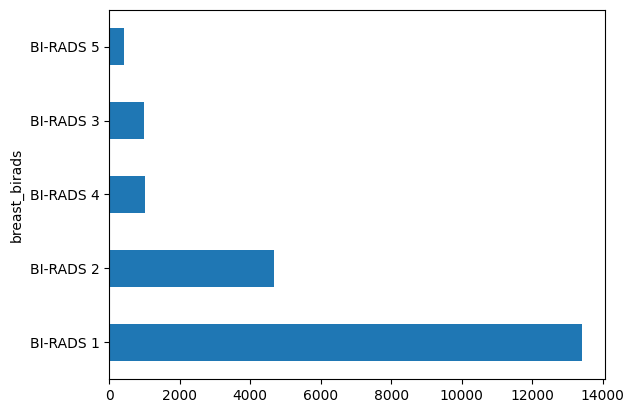

In [17]:
data['breast_birads'].value_counts().plot(kind='barh');

#BI-RADS 1 & BI-RADS 2 are the most prevalent, this is understandable as those are the lowest diagnostic indicators of breast cancer

How does the distribution of our breast Density for those with abnormality findings compare to those without?

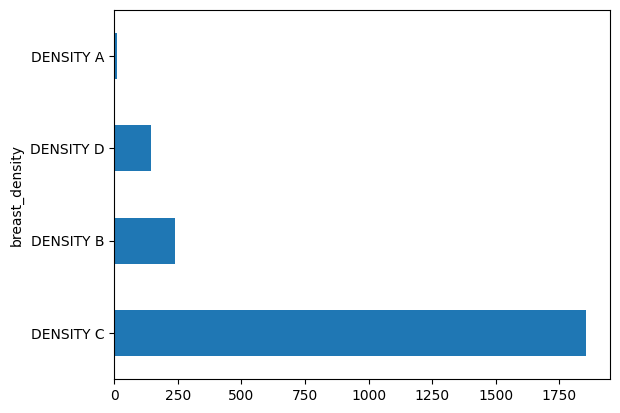

In [18]:
dw['breast_density'].value_counts().plot(kind='barh');

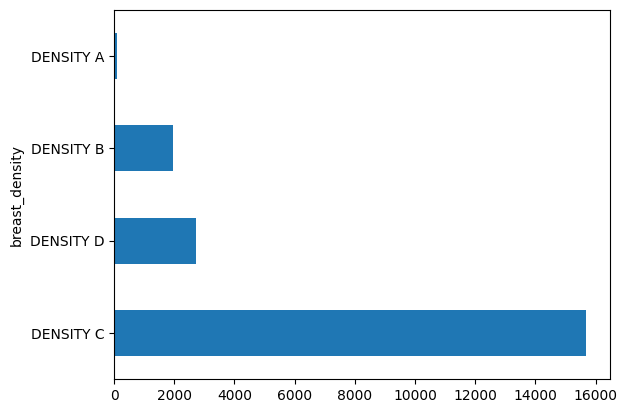

In [19]:
data['breast_density'].value_counts().plot(kind='barh');

#Breast Density Distribution for those with abnormality findings and those without seem to be quite similar

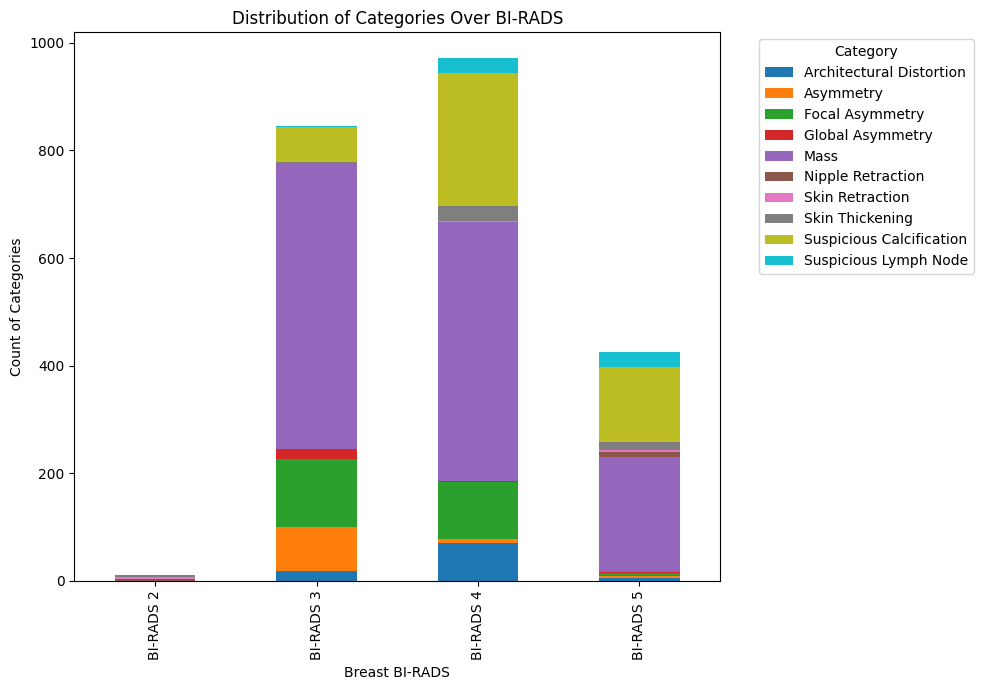

In [20]:
# Group data by 'breast_birads' and 'category', and count occurrences of 'category'
grouped_data = dw.groupby(['breast_birads', 'category']).size().unstack(fill_value=0)

# Plotting the data
ax = grouped_data.plot(kind='bar', stacked=True, figsize=(10, 7))
plt.title('Distribution of Categories Over BI-RADS')
plt.xlabel('Breast BI-RADS')
plt.ylabel('Count of Categories')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

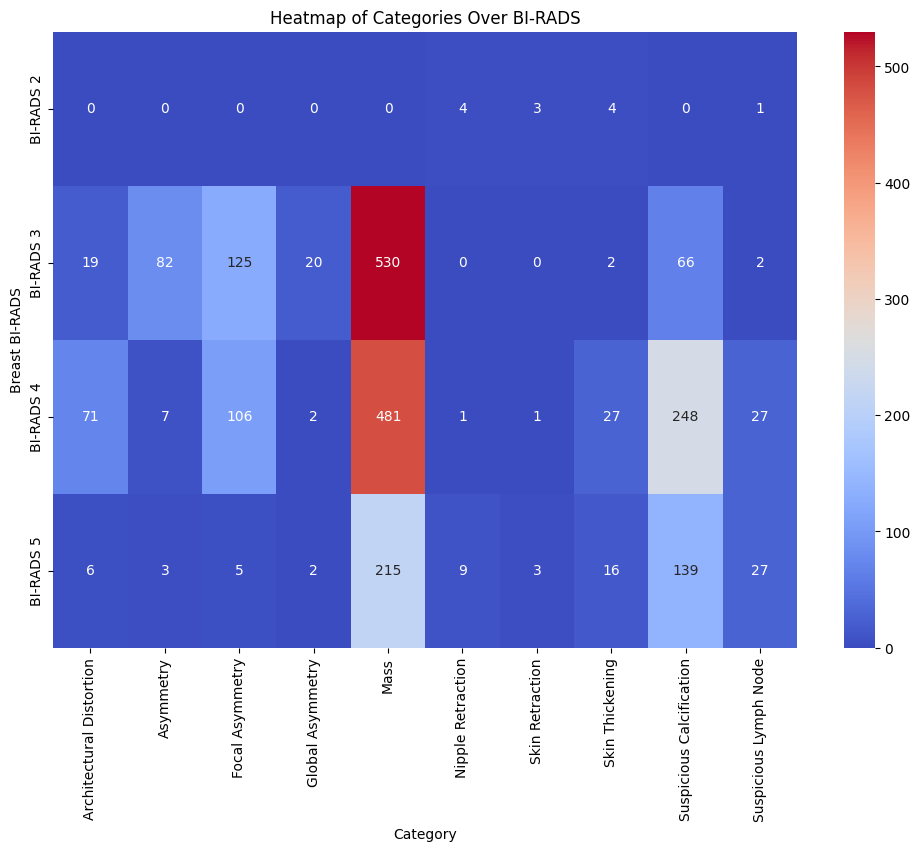

In [21]:
grouped_data = dw.groupby(['breast_birads', 'category']).size().unstack(fill_value=0)

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(grouped_data, annot=True, cmap='coolwarm', fmt="d")
plt.title('Heatmap of Categories Over BI-RADS')
plt.xlabel('Category')
plt.ylabel('Breast BI-RADS')
plt.show()


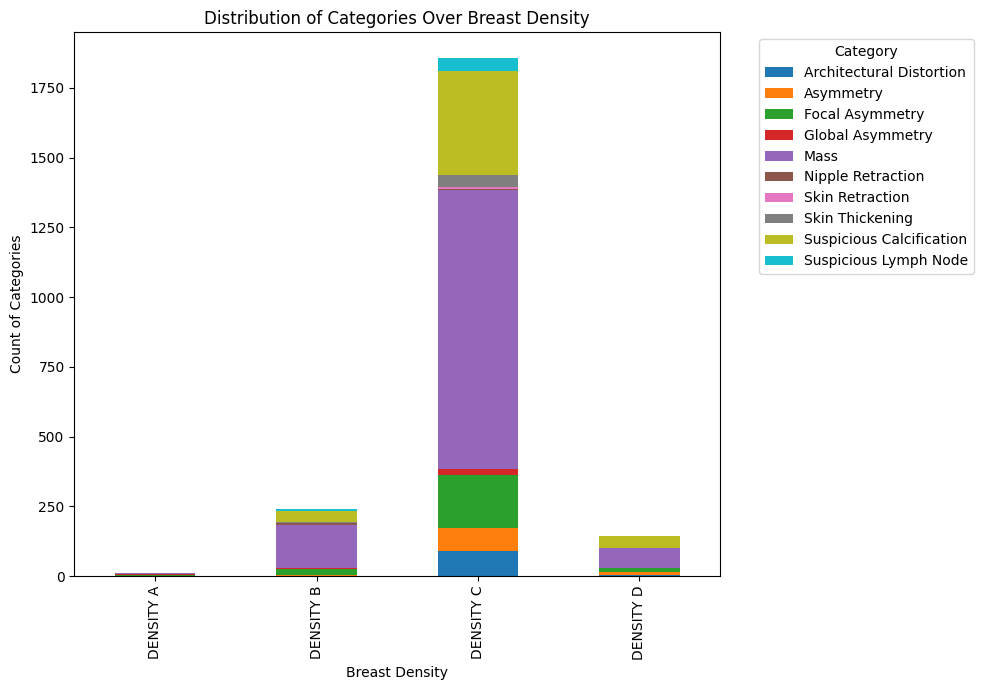

In [22]:
# Group data by 'breast_birads' and 'category', and count occurrences of 'category'
grouped_data = dw.groupby(['breast_density', 'category']).size().unstack(fill_value=0)

# Plotting the data
ax = grouped_data.plot(kind='bar', stacked=True, figsize=(10, 7))
plt.title('Distribution of Categories Over Breast Density')
plt.xlabel('Breast Density')
plt.ylabel('Count of Categories')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

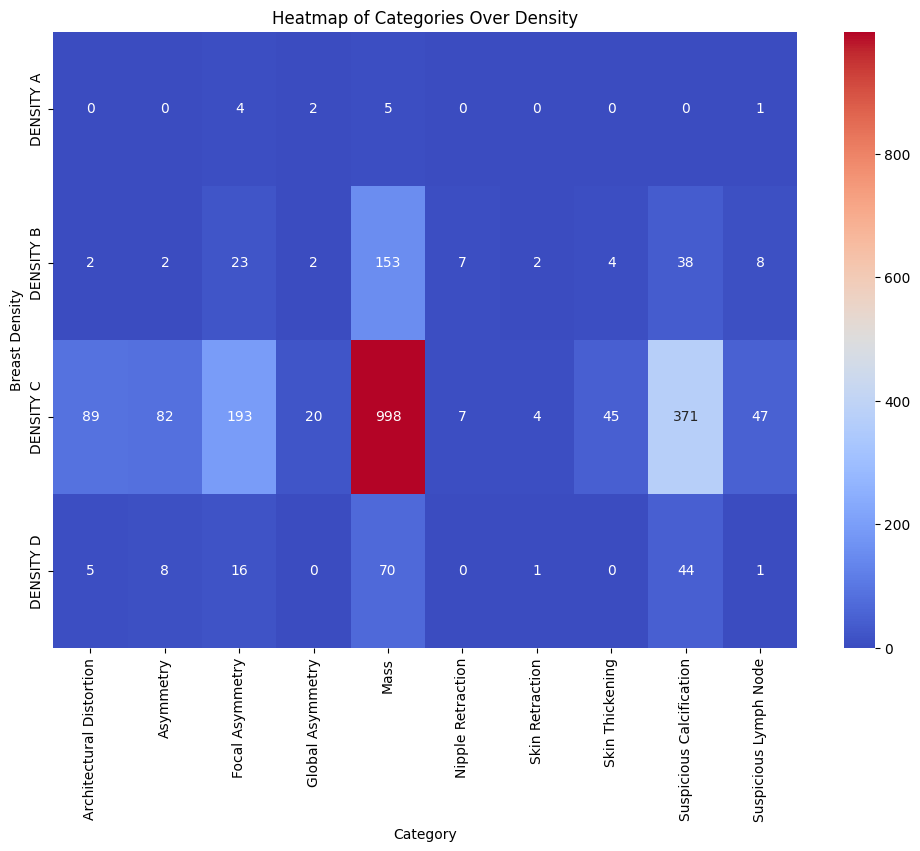

In [23]:
grouped_data = dw.groupby(['breast_density', 'category']).size().unstack(fill_value=0)

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(grouped_data, annot=True, cmap='coolwarm', fmt="d")
plt.title('Heatmap of Categories Over Density')
plt.xlabel('Category')
plt.ylabel('Breast Density')
plt.show()
